Found 5154 files belonging to 3 classes.
Class names: ['AD', 'CI', 'CN']
Training Residual Net...
Epoch 1/10, Train Loss: 1.0809, Validation Loss: 1.0115, Accuracy: 51.41%
Epoch 2/10, Train Loss: 1.0514, Validation Loss: 1.0033, Accuracy: 51.70%
Epoch 3/10, Train Loss: 1.0016, Validation Loss: 0.9825, Accuracy: 55.19%
Epoch 4/10, Train Loss: 0.9590, Validation Loss: 0.9096, Accuracy: 58.20%
Epoch 5/10, Train Loss: 0.8981, Validation Loss: 1.1198, Accuracy: 43.84%
Epoch 6/10, Train Loss: 0.8835, Validation Loss: 0.8175, Accuracy: 60.14%
Epoch 7/10, Train Loss: 0.8057, Validation Loss: 0.9328, Accuracy: 56.64%
Epoch 8/10, Train Loss: 0.7586, Validation Loss: 0.9019, Accuracy: 58.49%
Epoch 9/10, Train Loss: 0.7025, Validation Loss: 0.6674, Accuracy: 71.68%
Epoch 10/10, Train Loss: 0.6518, Validation Loss: 0.8229, Accuracy: 64.21%


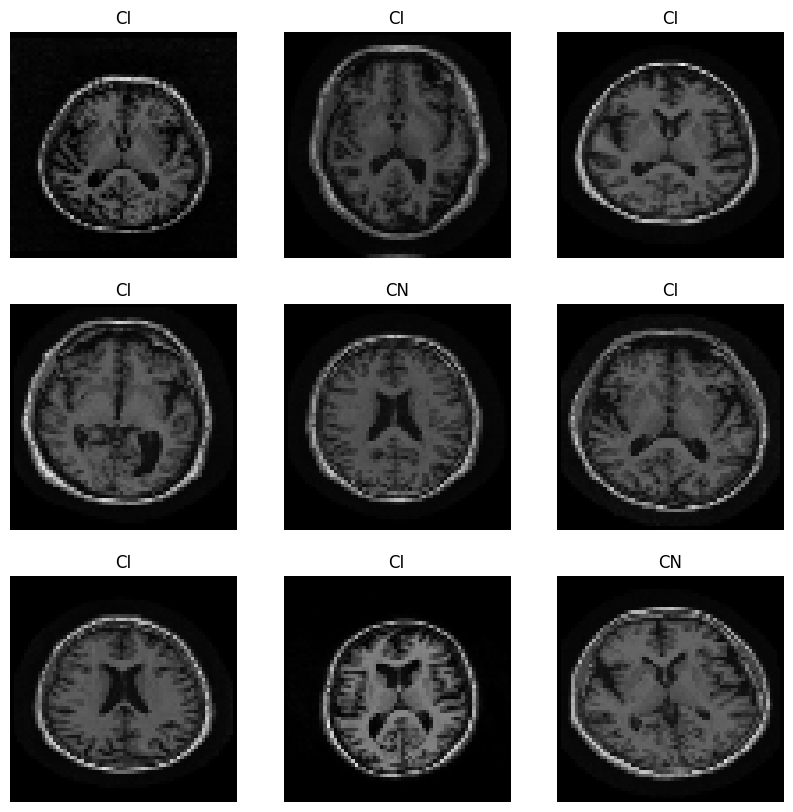

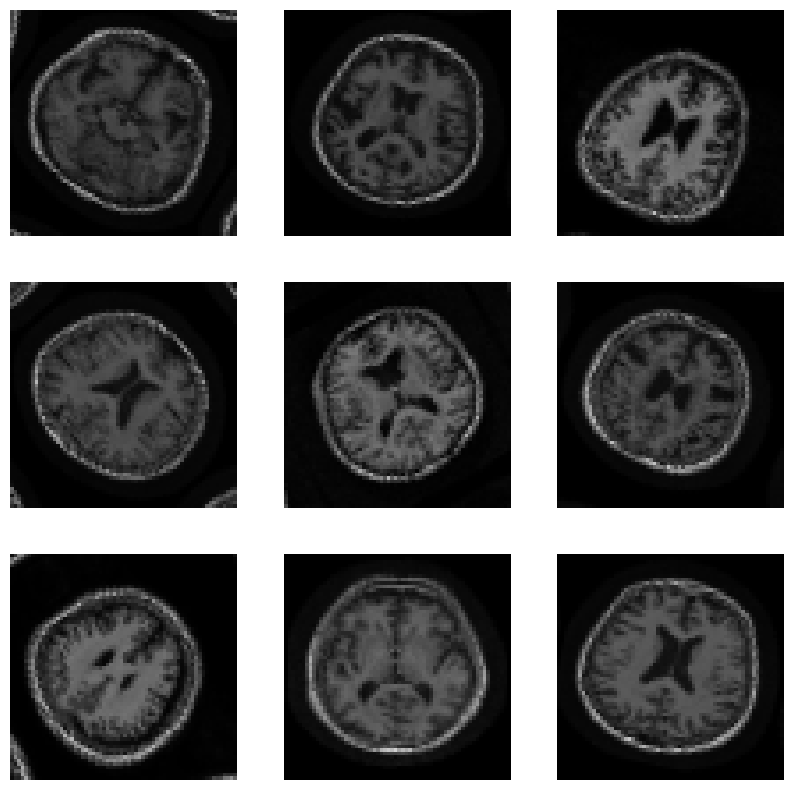

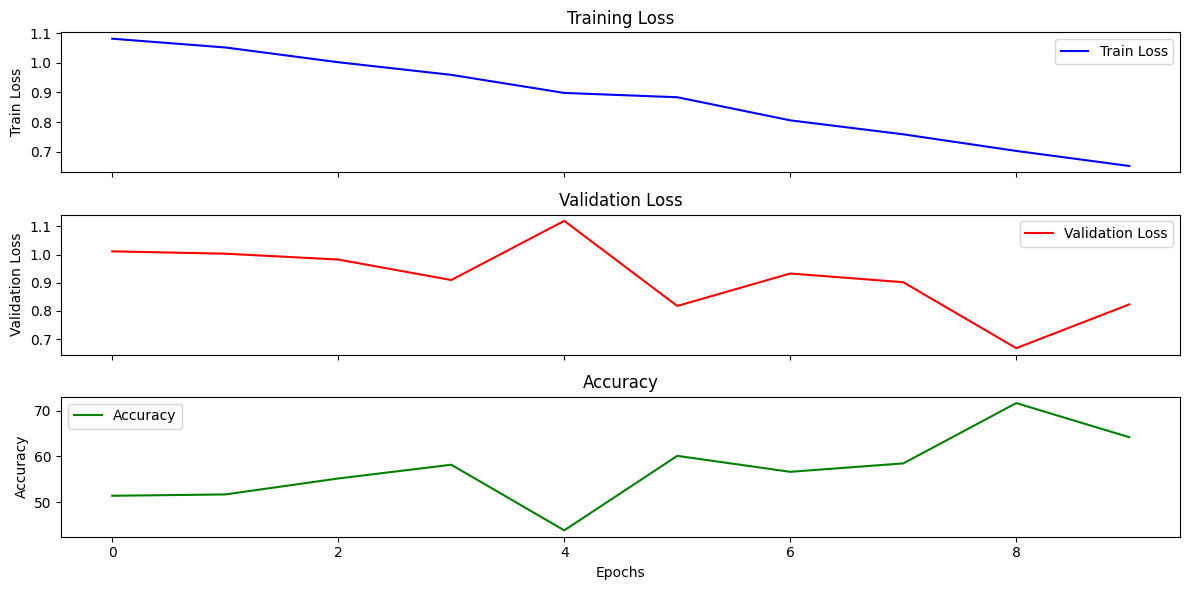

Training Efficient Net...
Epoch 1/10, Train Loss: 1.1364, Validation Loss: 0.9980, Accuracy: 54.41%
Epoch 2/10, Train Loss: 1.0709, Validation Loss: 1.0185, Accuracy: 52.67%
Epoch 3/10, Train Loss: 1.0598, Validation Loss: 1.0912, Accuracy: 52.28%
Epoch 4/10, Train Loss: 1.0461, Validation Loss: 1.0716, Accuracy: 51.89%
Epoch 5/10, Train Loss: 1.0331, Validation Loss: 1.5481, Accuracy: 39.67%
Epoch 6/10, Train Loss: 1.0330, Validation Loss: 1.1074, Accuracy: 44.71%
Epoch 7/10, Train Loss: 1.0335, Validation Loss: 1.1466, Accuracy: 53.83%
Epoch 8/10, Train Loss: 1.0293, Validation Loss: 0.9929, Accuracy: 53.83%
Epoch 9/10, Train Loss: 1.0175, Validation Loss: 1.0018, Accuracy: 54.03%
Epoch 10/10, Train Loss: 1.0295, Validation Loss: 1.1158, Accuracy: 51.50%


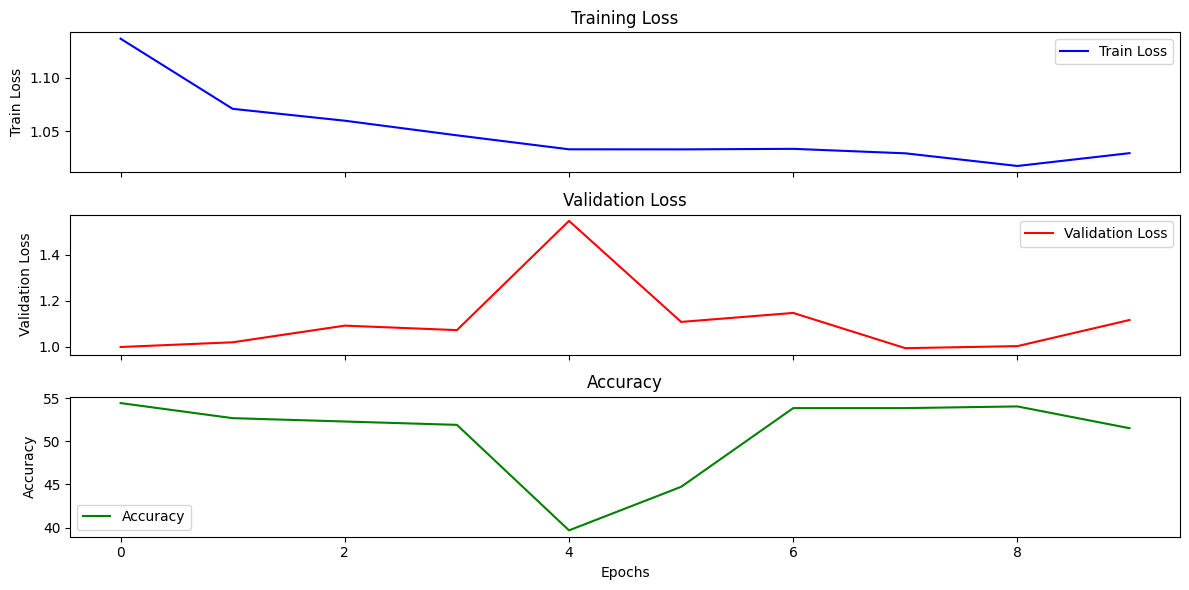

Training Mobile Net...
Epoch 1/10, Train Loss: 1.1493, Validation Loss: 1.0310, Accuracy: 53.25%
Epoch 2/10, Train Loss: 1.0657, Validation Loss: 0.9888, Accuracy: 53.15%
Epoch 3/10, Train Loss: 1.0543, Validation Loss: 1.0572, Accuracy: 52.67%
Epoch 4/10, Train Loss: 1.0273, Validation Loss: 0.9783, Accuracy: 55.19%
Epoch 5/10, Train Loss: 1.0011, Validation Loss: 0.9529, Accuracy: 55.58%
Epoch 6/10, Train Loss: 0.9777, Validation Loss: 0.9663, Accuracy: 54.22%
Epoch 7/10, Train Loss: 0.9876, Validation Loss: 1.1100, Accuracy: 53.64%
Epoch 8/10, Train Loss: 0.9845, Validation Loss: 1.0303, Accuracy: 50.92%
Epoch 9/10, Train Loss: 0.9764, Validation Loss: 0.9769, Accuracy: 53.83%
Epoch 10/10, Train Loss: 0.9622, Validation Loss: 0.8914, Accuracy: 56.74%


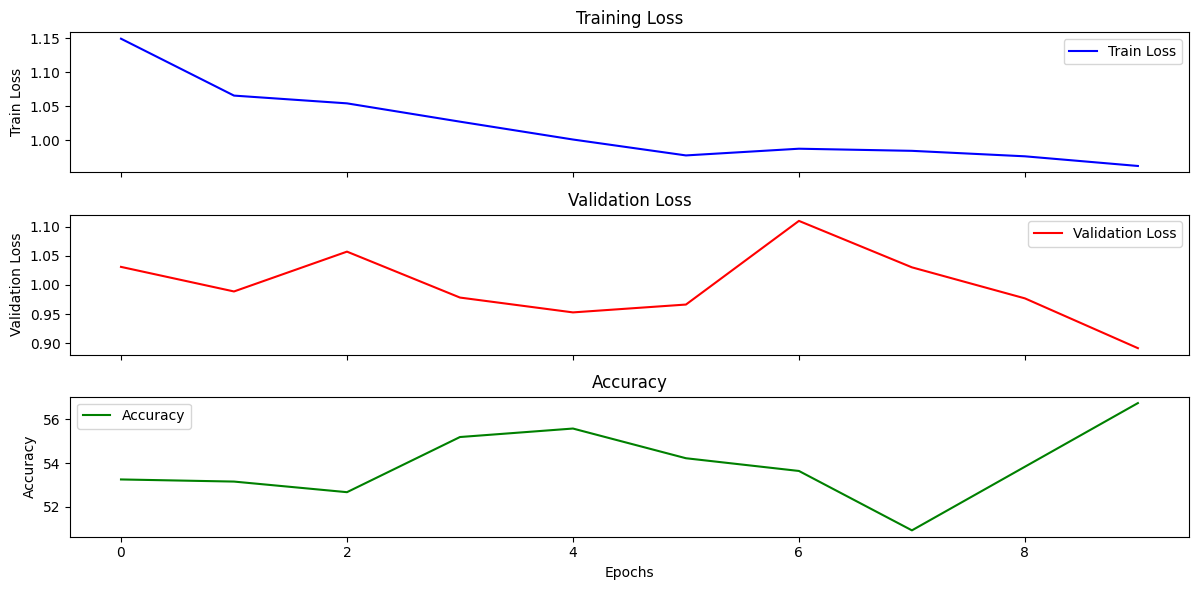

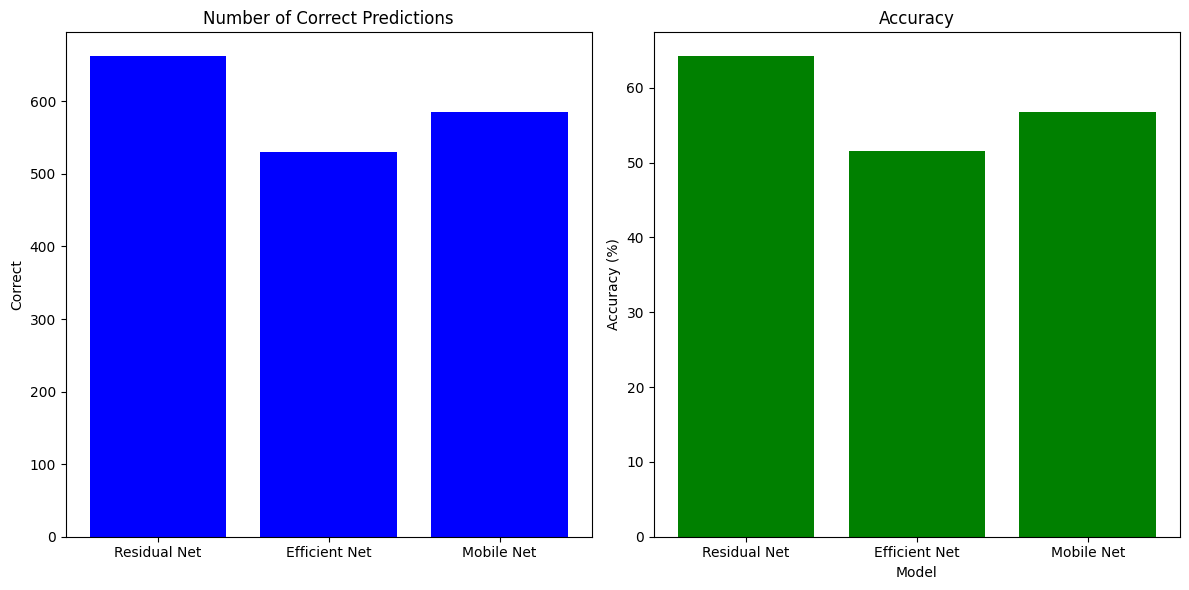

Residual Net | Correct: 662 Total: 1031 Accuracy 64.21%
Efficient Net | Correct: 530 Total: 1031 Accuracy 51.50%
Mobile Net | Correct: 585 Total: 1031 Accuracy 56.74%
Residual Net: CN
Efficient Net: CI
Mobile Net: CI


In [17]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = True

def clear_cache():
    torch.cuda.empty_cache()

# Parameters
IMG_SIZE = 64  # Reduced image size to save memory
BATCH_SIZE = 8  # Further reduced batch size to avoid memory issues
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 3

# Step 1: Data Collection (from alz.ipynb)
data_path = r"/kaggle/input/adni-extracted-axial/Axial"
data = tf.keras.utils.image_dataset_from_directory(
    directory=data_path, 
    image_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=10000
)

class_names = data.class_names
print("Class names:", class_names)

# Step 2: Data Visualization
def visualize_sample_data(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

visualize_sample_data(data)

# Step 3: Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

def augment_sample_images(dataset):
    for images, _ in dataset.take(1):
        augmented_images = data_augmentation(images)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")

augment_sample_images(data)

# Step 4: Data Preprocessing and Preparation
X, y = [], []
for images, labels in data:
    augmented_images = data_augmentation(images)
    X.append(augmented_images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X, axis=0) / 255.0  # Normalize images to [0, 1]
y = np.concatenate(y, axis=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Convert TensorFlow data to PyTorch Dataset
class AlzheimerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)  # Convert label to LongTensor
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = AlzheimerDataset(X_train, y_train, transform=transform)
val_dataset = AlzheimerDataset(X_val, y_val, transform=transform)

def predict_img_file(models, image_path):
    from PIL import Image
    image = Image.open(image_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)

    predictions = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for name, model in models.items():
        model.eval()
        model = model.to(device)
        with torch.no_grad():
            output = model(image.to(device))
            _, predicted = torch.max(output, 1)
            predictions[name] = class_names[predicted.item()]

    return predictions

def print_predictions(predictions):
    for model, prediction in predictions.items():
        print(f"{model}: {prediction}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 6: Define Models (from sign.ipynb)
class TernaryClassifier(nn.Module):
    def __init__(self, base_model, model_type):
        super(TernaryClassifier, self).__init__()
        self.base_model = base_model
        if model_type == "resnet":
            self.fc = nn.Linear(base_model.fc.in_features, NUM_CLASSES)
            self.base_model.fc = self.fc
        elif model_type in ["efficientnet", "mobilenet"]:
            if model_type == "efficientnet":
                self.fc = nn.Linear(base_model.classifier[1].in_features, NUM_CLASSES)
                base_model.classifier[1] = self.fc
            elif model_type == "mobilenet":
                self.fc = nn.Linear(base_model.classifier[-1].in_features, NUM_CLASSES)
                base_model.classifier[-1] = self.fc

    def forward(self, x):
        return self.base_model(x)

# Load models without pretrained weights
resnet = models.resnet18(pretrained=False)
efficientnet = models.efficientnet_b0(pretrained=False)
mobilenet = models.mobilenet_v2(pretrained=False)

models_dict = {
    "Residual Net": TernaryClassifier(resnet, "resnet"),
    "Efficient Net": TernaryClassifier(efficientnet, "efficientnet"),
    "Mobile Net": TernaryClassifier(mobilenet, "mobilenet")
}

# Step 7: Train and Evaluate Models
def train_and_evaluate(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler()  # Use mixed precision training

    train_loss_list, val_loss_list, accuracy_list = [], [], []

    accumulation_steps = 2  # Gradient accumulation to simulate larger batch size

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.item() * accumulation_steps

        avg_train_loss = running_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")
        clear_cache()

    return train_loss_list, val_loss_list, accuracy_list

def show_graphs(train_loss_list, val_loss_list, accuracy_list):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    ax1.plot(train_loss_list, color='blue', label='Train Loss')
    ax1.set_ylabel('Train Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax2.plot(val_loss_list, color='red', label='Validation Loss')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss')
    ax2.legend()
    ax3.plot(accuracy_list, color='green', label='Accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy')
    ax3.legend()
    plt.tight_layout()
    plt.show()

def plot_print_test_results(correct_values, counter_value, accuracy_values, model_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
    ax1.bar(model_names, correct_values, color='blue')
    ax1.set_ylabel('Correct')
    ax1.set_title('Number of Correct Predictions')
    ax2.bar(model_names, accuracy_values, color='green')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy')
    plt.tight_layout()
    plt.show()
    for i in range(len(model_names)):
        name = model_names[i]
        print(f"{name} | Correct: {correct_values[i]} Total: {counter_value} Accuracy {accuracy_values[i]:.2f}%")

# Train models one at a time and collect results
model_names, correct_values, accuracy_values = [], [], []
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    train_loss, val_loss, accuracy = train_and_evaluate(model, train_loader, val_loader, EPOCHS, LEARNING_RATE)
    show_graphs(train_loss, val_loss, accuracy)

    # Collect metrics for later comparison
    correct_values.append(int((accuracy[-1] / 100) * len(val_dataset)))
    accuracy_values.append(accuracy[-1])
    model_names.append(model_name)

# Compare results
plot_print_test_results(correct_values, len(val_dataset), accuracy_values, model_names)

# Test a sample image
image_path = "/kaggle/input/adni-extracted-axial/Axial/AD/AD002_S_0816a076.png"  # Replace with the actual path to the uploaded image
predictions = predict_img_file(models_dict, image_path)
print_predictions(predictions)
